In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation


In [81]:
ticker = "XBTUSD"
frequency = "60"

df = pd.read_csv(f"data/silver_prices/{ticker}_{frequency}_silver.csv")
df.head()


,timestamp,open,high,low,close,volume,0,1,2,3,...,hilberttransformdominantcycleperiod_1,hilberttransformdominantcyclephase_1,hilberttransformtrendmode_1,return_2n,return_4n,return_8n,return_16n,return_32n,return_64n,return_256n
0,1.710029e+09,68459.1,68603.5,68390.5,68522.4,30.696237,1.710029e+09,NaN,NaN,NaN,...,NaN,NaN,0.0,0.006532,0.014792,0.017915,0.015620,0.039076,0.029151,-0.079383
1,1.710032e+09,68522.4,69386.9,68493.6,69100.0,200.714179,1.710032e+09,NaN,NaN,NaN,...,NaN,NaN,0.0,0.002343,0.005480,0.011766,0.006993,0.038957,0.029687,-0.072227
2,1.710036e+09,69100.0,69300.0,68970.0,68970.0,44.291501,1.710036e+09,NaN,NaN,NaN,...,NaN,NaN,0.0,0.008206,0.006949,0.013277,0.006036,0.036439,0.035102,-0.051609
3,1.710040e+09,68969.6,69265.9,68872.0,69261.9,35.099245,1.710040e+09,NaN,NaN,NaN,...,NaN,NaN,0.0,0.003130,0.003472,0.006299,0.003799,0.033147,0.030594,-0.050465
4,1.710043e+09,69257.7,69734.1,69179.6,69536.0,262.228963,1.710043e+09,NaN,NaN,NaN,...,NaN,NaN,0.0,-0.001247,0.003078,0.005235,-0.001635,0.035014,0.021339,-0.035162


In [82]:
target = "return_8n"

In [83]:
scaler = MinMaxScaler()

close_price = df[target].values.reshape(-1, 1)


scaled_close = scaler.fit_transform(close_price)
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)


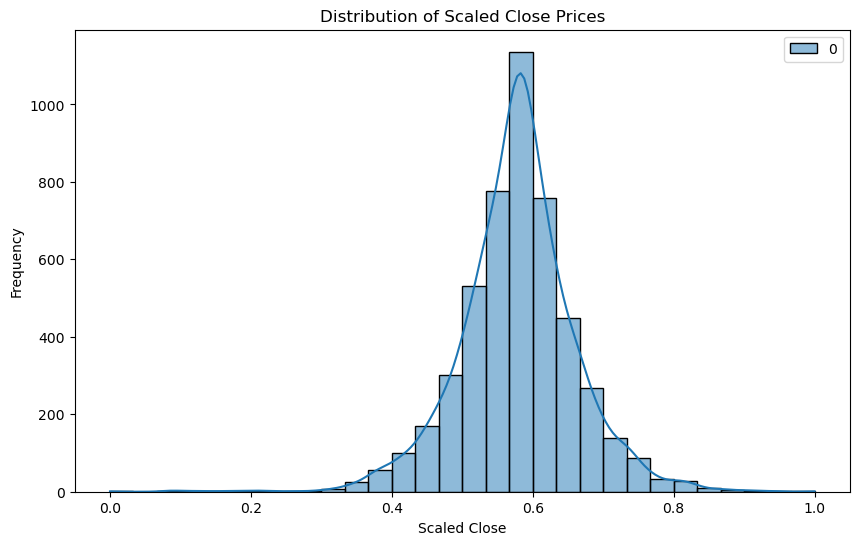

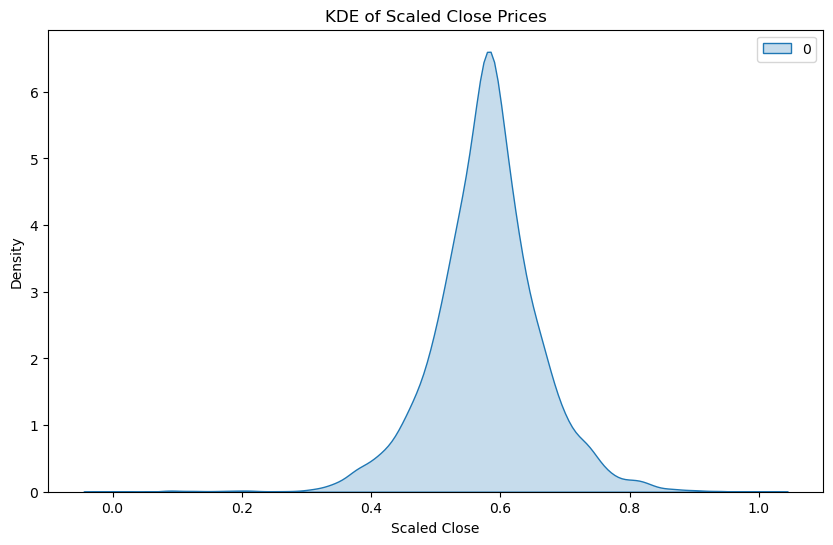

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
# df = pd.read_csv('your_data.csv')
# Assume df['scaled_close'] is your target variable.

# Visualize the distribution using histplot
plt.figure(figsize=(10, 6))
sns.histplot(scaled_close, bins=30, kde=True)
plt.title('Distribution of Scaled Close Prices')
plt.xlabel('Scaled Close')
plt.ylabel('Frequency')
plt.show()

# Alternatively, you can use kdeplot
plt.figure(figsize=(10, 6))
sns.kdeplot(scaled_close, fill=True)
plt.title('KDE of Scaled Close Prices')
plt.xlabel('Scaled Close')
plt.ylabel('Density')
plt.show()


In [85]:

scaled_close = scaled_close[~np.isnan(scaled_close)]
# scaled_close = np.power(scaled_close, 2)  # Squaring increases variance
scaled_close = scaled_close.reshape(-1, 1)

LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is:

[batch_size, sequence_length, n_features]
We also want to save some data for testing. Let’s build some sequences:


In [86]:

SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

We’re creating a 3 layer LSTM Recurrent Neural Network. We use Dropout with a rate of 20% to combat overfitting during training:

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Set your constants
DROPOUT = 0.2
SEQ_LEN = 100  # Set this to your desired sequence length
WINDOW_SIZE = SEQ_LEN - 1

# Define the model
model = Sequential()

model.add(Bidirectional(
    LSTM(WINDOW_SIZE, return_sequences=True),  # Use LSTM directly
    input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

# Add more layers as needed...
model.add(Dense(1))  # Example output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

model.add(Activation('linear'))

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 99, 198)        │        79,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 99, 198)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 99, 1)          │           199 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,191 (313.25 KB)

 Trainable params: 80,191 (313.25 KB)

 Non-trainable params: 0 (0.00 B)

Our output layer has a single neuron (predicted Bitcoin price). We use Linear activation function which activation is proportional to the input.

<h1>Training<strong></h1>
We’ll use Mean Squared Error as a loss function and Adam optimizer.



In [88]:

# BATCH_SIZE = 32

# model.compile(
#     loss='mean_squared_error',
#     optimizer='adam'
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=15,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     validation_split=0.1


In [89]:
import mlflow
import mlflow.keras
from datetime import datetime

today = datetime.now().strftime("%Y-%m-%d")

# Set the experiment name (optional)
mlflow.set_experiment(f"{ticker}_{frequency}_{target}_experiment")

BATCH_SIZE = 32

with mlflow.start_run():
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )

    # Log parameters
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", 15)
    mlflow.log_param("optimizer", "adam")

    history = model.fit(
        X_train,
        y_train,
        epochs=15,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.1
    )

    # Log metrics
    mlflow.log_metric("final_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])

    # Log the model to MLflow
    # mlflow.keras.log_model(model, "model")

    # Save the model locally
    # model.save(f"models/{ticker}_{frequency}_model_{today}.h5") 

    


2024/10/31 19:09:21 INFO mlflow.tracking.fluent: Experiment with name 'XBTUSD_60_return_8n_experiment' does not exist. Creating a new experiment.


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0416 - val_loss: 0.0097
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0132 - val_loss: 0.0090
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0121 - val_loss: 0.0083
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0106 - val_loss: 0.0065
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0104 - val_loss: 0.0063
Epoch 8/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0101 - val_loss: 0.0062
Epoch 9/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 10/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 11/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0097 - val_loss: 0.0060
Epoch 12/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 

In [90]:
from mlflow.models import infer_signature

# After your model training and before logging the model
signature = infer_signature(X_train, model.predict(X_train))

with mlflow.start_run():
    mlflow.keras.log_model(model, "model", signature=signature)
    # Save the model locally
    model.save(f"models/{ticker}_{frequency}_{target}_{today}.h5")

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [91]:
y_hat = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [92]:
# len(y_test)

In [93]:
# y_hat has shape (batch_size, timesteps, features)
# Select the last timestep for inverse transformation
# # y_hat_last_timestep = y_hat[:, -1, :]  # Shape (batch_size, features)

# # # Now apply the inverse transform
# # y_hat_inverse = scaler.inverse_transform(y_hat_last_timestep)
# y_test_inverse = scaler.inverse_transform(y_test)
# y_hat_inverse = scaler.inverse_transform(y_hat.flatten())
# Assuming y_hat has shape (batch_size, timesteps, features)
y_hat = model.predict(X_test)
# Select the last timestep
# Assuming y_hat has shape (batch_size, timesteps, features)
# Select the last timestep for predictions
y_hat_last_timestep = y_hat[:, -1, :]  # Make sure y_hat has the expected shape

# Inverse transform the predictions
y_hat_inverse = scaler.inverse_transform(y_hat_last_timestep)

# Assuming y_test is a 2D array (if you're using a sequence of values)
# If y_test was reshaped correctly when prepared, do this:
y_test_inverse = scaler.inverse_transform(y_test)

# If y_test needs to be handled differently (e.g., if you also want only the last timestep)
# You need to check how y_test is shaped
if y_test.ndim == 3:
    y_test_last_timestep = y_test[:, -1, :]  # Only if y_test is 3D
    y_test_inverse = scaler.inverse_transform(y_test_last_timestep)



In [94]:

# y_hat_inverse = y_hat_inverse - np.median(y_hat_inverse)

In [95]:
# np.median(y_test_inverse)

Predicted shape: (240,)
Actual shape: (240,)
Mean Absolute Error: 0.0165
Mean Squared Error: 0.0004
R-squared: -1.4325


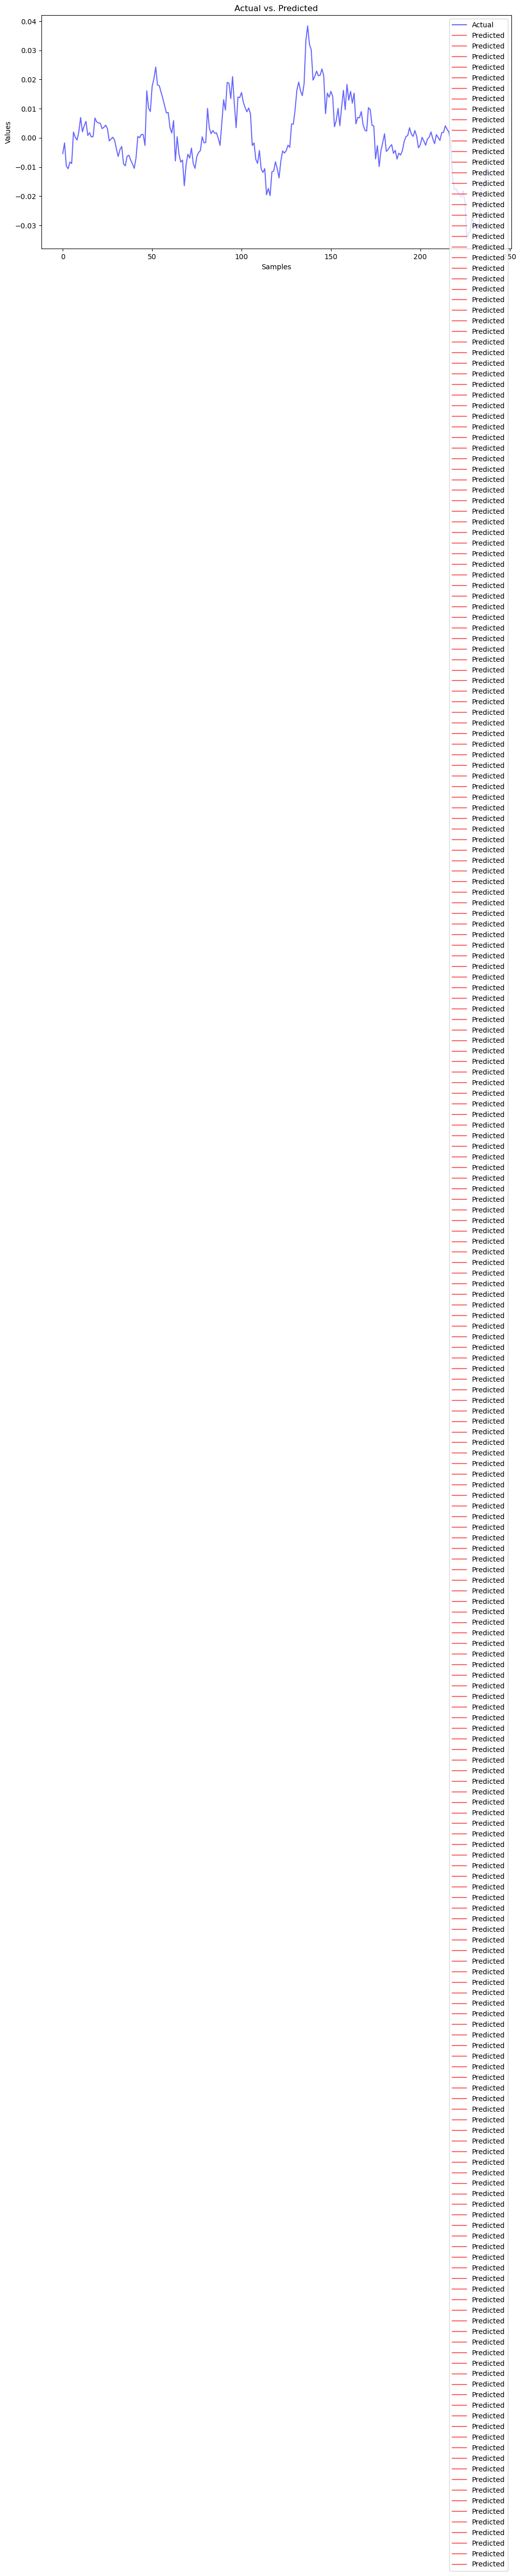

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume y_hat_inverse and y_test_inverse are already defined and inverse transformed
front = 0
back = 100
# Ensure y_hat_inverse and y_test_inverse are flattened if needed
y_hat_inverse = y_hat_inverse.flatten()
y_test_inverse = y_test_inverse.flatten()

# Check shapes
print("Predicted shape:", y_hat_inverse.shape)
print("Actual shape:", y_test_inverse.shape)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
mse = mean_squared_error(y_test_inverse, y_hat_inverse)
r2 = r2_score(y_test_inverse, y_hat_inverse)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual', color='blue', alpha=0.6)
plt.plot(((y_hat_inverse,)), label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs. Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()


<Axes: ylabel='Count'>

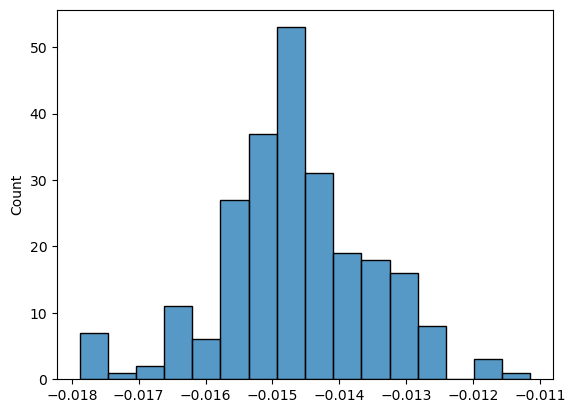

In [97]:
sns.histplot(y_hat_inverse)

<Axes: ylabel='Count'>

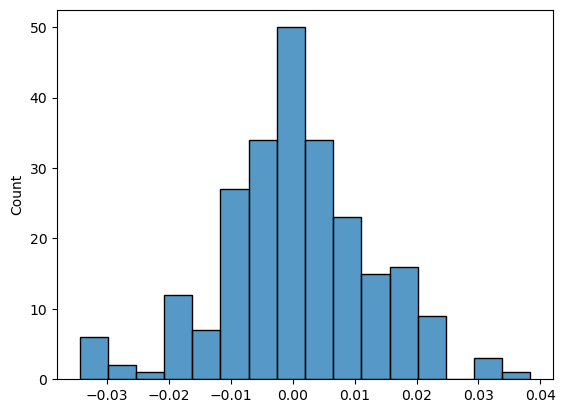

In [98]:
sns.histplot(y_test_inverse)
